### Demonstrativos financeiros

Uma companhia de capital aberto deve apurar as seguintes demonstrações em atendimento às exigências da Comissão de Valores Mobiliários (CVM), B3 e seus acionistas:

*Demonstrações Financeiras Padronizadas* (DFP) – Este documento é composto por todos os demonstrativos financeiros referentes ao exercício social encerrado, e deve ser encaminhado ao final de cada trimestre de cada ano à CVM e à B3. https://dados.cvm.gov.br/dataset/cia_aberta-doc-dfp 
Deve ser entregue pelo emissor nacional em até 3 (três) meses contados do encerramento do exercício social ou na mesma data de envio das demonstrações financeiras, o que ocorrer primeiro.

*Informações e Resultados Trimestrais* (ITR) – São elaborados e enviados por todas as companhias listadas em Bolsa de Valores para a CVM e B3 todo trimestre. A ITR tem por finalidade permitir que o investidor acompanhe o desempenho da empresa no trimestre. https://dados.cvm.gov.br/dataset/cia_aberta-doc-itr
Deve ser entregue pelo emissor no prazo de 45 (quarenta e cinco) dias contados da data de encerramento
de cada trimestre.

Relatórios contábeis elaborados periodicamente pelas empresas. 
- Balanço Patrimonial Ativo (BPA)
- Balanço Patrimonial Passivo (BPP)
- Demonstração de Fluxo de Caixa - Método Direto (DFC-MD)
- Demonstração de Fluxo de Caixa - Método Indireto (DFC-MI)
- Demonstração das Mutações do Patrimônio Líquido (DMPL)
- Demonstração de Resultado Abrangente (DRA)
- Demonstração de Resultado (DRE)
- Demonstração de Valor Adicionado (DVA)

Os arquivos contêm duas versões: consolidadas (con) e indivuduais (ind):

'itr_cia_aberta_DRE_ind_2023.csv' - apenas a própria empresa, desconsiderando suas subsidiadas

'itr_cia_aberta_DRE_con_2023.csv' - contemplam todas as empresas do grupo que a empresa possui participação, e.g. no caso de uma holding 

Os demonstrativos consolidados são os mais usados pelo mercado. Filtros deixar só informações necessárias:
 - ORDEM_EXERC linhas  com 'PENÚLTIMO' e 'ÚTIMO'. Usar o segundo, o outro é do ano anterior.
 - DT_FIM_EXERC no caso do ITR é  última data  do trimestre referente ao dado. Nos arquivos DFP há apenas o  mês 12.
 - DT_INI_EXERC. Quando mão aparece no demonstrativo, o valor mostrado representa a posição no final do semestre. Quando esse campo aparece, o valor corresponde ao total do período entre a data inicial (DT_INI_EXERC) e a data final (DT_FIM_EXERC). Pode aparecer em mais de uma linha, indicando períodos diferentes:

| Empresa | Conta   | DT_INI_EXERC | DT_FIM_EXERC | Valor |
| ------- | ------- | ------------ | ------------ | ----- |
| A       | Receita | 01/01/2023   | 30/06/2023   | 500   |
| A       | Receita | 01/04/2023   | 30/06/2023   | 300   |


In [96]:
ano_inicio  = 2023
ano_fim     = 2024 # Evite colocar ano onde não há dados ainda
empresa     = 'vale' 

In [46]:
import os
import pandas as pd
import urllib.request
from zipfile import ZipFile

In [105]:
def get_data( start_year , end_year , annual = True , dl = False) : 

    '''Baixa demonstrativos financeiros do site da CVM

    Args:
        start_year (int): ano inicial
        end_year (int): ano final        
        annual (bool): se True, baixa relatorio anual (DFP), senão trimestral (ITR)
        dl (bool): se True, faz download, senão lê copia local 

    Returns:
        caminho e/dos Arquivos com os dados reunidos por ano.
'''

    if annual : relP = 'dfp'
    else :      relP = 'itr'

    path_code = os.getcwd()
    path_data = os.path.join(path_code, 'data')

 
    url_cvm = f'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/{relP.upper()}/DADOS/'

    if dl :                 
        for ano in range(start_year, end_year + 1):
            arquivo_zip = f'{relP}_cia_aberta_{ano}.zip'
            url = url_cvm + arquivo_zip
            # Combina path_data com o nome do arquivo extraído da URL.
            arquivo_local = os.path.join(path_data, arquivo_zip)
            #Baixa o arquivo da URL e o salva no caminho especificado por arquivo_local.
            urllib.request.urlretrieve(url, arquivo_local) 
            # extractall(): Extrai o conteúdo do arquivo ZIP para o diretório indicado
    else : 
        for ano in range(start_year, end_year + 1):
            arquivo_zip = f'{relP}_cia_aberta_{ano}.zip'
            url = url_cvm + arquivo_zip
            # Combina path_data com o nome do arquivo extraído da URL.
            arquivo_local = os.path.join(path_data, arquivo_zip)

            try:
                if not os.path.exists(arquivo_local):
                    print(f"Baixando {arquivo_zip}...")
                #Baixa o arquivo da URL e o salva no caminho especificado por arquivo_local.
                    urllib.request.urlretrieve(url, arquivo_local) 
                # Abre o arquivo ZIP baixado para leitura ('r').
            except Exception as e:
                print(f"Erro ao processar ano {ano}: {e}")

    
        
    return path_data


In [106]:
path=get_data( start_year = ano_inicio, end_year = ano_fim )

In [107]:
path

'/home/yair/GHub/Finance-playground/data'

In [ ]:
    path_unzip= os.path.join(path_data, relP)
#  report (list): lista os relatorios que deseja (consolidado): cc trimestral
#             'BPA_con', 'BPP_con', 'DRE_con', 'DFC_MD_con', 'DFC_MI_con', 'DMPL_con'

In [ ]:
   # Criar pastas se não existirem
    os.makedirs(path_unzip, exist_ok=True)

In [ ]:
    #remove os arquivos baixados
    if rmzip: 
        for filename in os.listdir(path_data):             
            if filename.endswith(".zip"): os.remove(os.path.join(path_data, filename))
        
    # # Remova quase todos os arquivos .csv
    for filename in os.listdir(path_unzip):
        file_path = os.path.join(path_unzip, filename)
        for relat in relatorios:
            if os.path.isfile(file_path) and filename.endswith('.csv') and 'cia_aberta' in filename and relat not in filename:
                os.remove(file_path)
                print(f"{file_path}", end=', ')

In [ ]:

        dados_dre = pd.DataFrame()

        # Concatena os dados em um DataFrame
        for planilhas in relatorios:
            demonstrativo = pd.DataFrame()
            for ano in range(start_year, end_year + 1):
                arquivo = f'{path_unzip}/{dreP}_cia_aberta_{planilhas}_{ano}.csv'
                if os.path.exists(arquivo):
                    le_arquivo = pd.read_csv(arquivo,sep = ';', decimal = ',', encoding = 'ISO-8859-1',dtype = {"ORDEM_EXERC": "category"})
                    frames=[demonstrativo, le_arquivo]
                    demonstrativo = pd.concat(frames)

            demonstrativo.to_csv(f'{path_unzip}/{dreP}_{planilhas}_{start_year}-{end_year}.csv', index = False) 


In [71]:

def show_table(data, conta=[]):
  
    ''' Mostra uma tabela organizada 

    Args:
        data (DataFrame): DataFrame do demonstrativo
        conta (list): Lista dos códigos das contas que se deseja filtrar

    Returns:
        DataFrame
'''

    # filtra as contas e as colunas de interesse
    data = data[data.CD_CONTA.isin(conta)][['DT_REFER','CD_CONTA','DS_CONTA','VL_CONTA']].drop_duplicates()
    data['DT_REFER'] = pd.to_datetime(data['DT_REFER'])
    data['Ano'] = data['DT_REFER'].dt.year.astype(str)
    data.reset_index(inplace = True, drop = True)

    data_pivot = data.pivot(index = ['CD_CONTA','DS_CONTA'], columns = 'Ano', values = 'VL_CONTA')

    year_cols = list(map(str,list(range(ano_inicio,ano_fim+1))))
    pct_changes = round(data_pivot[year_cols].pct_change(axis=1).iloc[:,1:] * 100, ndigits = 2)
    pct_changes.columns = [f'{start}-{end} Δ%' for start, end in zip(year_cols[:-1], year_cols[1:])]

    colunas_intercaladas = [col for pair in zip(data_pivot.columns, pct_changes.columns) for col in pair]
    colunas_intercaladas.append(data_pivot.columns[-1])

    return pd.concat([data_pivot, pct_changes], axis=1)[colunas_intercaladas]
#   return data_pivot


# DRE

In [92]:
path=get_data( start_year = ano_inicio, end_year = ano_fim , reports = ['DRE'] , rmzip=True , dl=False)

['DRE_con']
/home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_2019.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DVA_ind_2021.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_BPP_con_2022.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DFC_MI_ind_2019.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DFC_MI_con_2023.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_2017.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DRA_con_2017.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DRA_con_2024.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DRE_ind_2021.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DFC_MD_ind_2020.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DRA_ind_2022.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DFC_MI_ind_2020.csv, /home/yair/GHub/Finance-playground/data/dfp/dfp_cia_aberta_DFC_MD_in

In [73]:
busca = empresa.strip().upper()
while True: 
    resultado = dre[dre['DENOM_CIA'].str.contains(busca)][['DENOM_CIA', 'CD_CVM']]
    if resultado.empty:
        print(f"Nenhum resultado encontrado para '{busca}'. Tente novamente com outra palavra-chave.")
        busca = input("Digite uma palavra-chave para buscar na coluna 'DENOM_CIA': ").strip().upper()
    else:
        print(resultado.drop_duplicates())
        break  # Sai do loop

       DENOM_CIA  CD_CVM
15382  VALE S.A.    4170


In [74]:
if len(resultado.drop_duplicates()[['CD_CVM']].values) == 1:
    cod_cvm = resultado.drop_duplicates()[['CD_CVM']].values[0][0]
else:   
    cod_cvm= int(input(f"Digite o código CVM dentre {list(resultado['CD_CVM'].drop_duplicates().values)}: "))
empresa = dre[dre['CD_CVM']==cod_cvm]['DENOM_CIA'].drop_duplicates().values[0]
empresa

'VALE S.A.'

In [75]:
tabela = dre[(dre['CD_CVM']==cod_cvm) & (dre['ORDEM_EXERC']=='ÚLTIMO')].copy()
tabela['DT_REFER']=pd.to_datetime(tabela['DT_REFER'].astype(str))
tabela['ano'] = tabela['DT_REFER'].dt.year

In [76]:
from IPython.display import display, HTML

padrao = r"^\d+\.\d{2}$"

conta = tabela[['CD_CONTA', 'DS_CONTA' , 'VL_CONTA']]
conta = tabela[(tabela['VL_CONTA']!=0) & (tabela['CD_CONTA'].str.match(padrao))][['CD_CONTA', 'DS_CONTA' , 'VL_CONTA','ano']]
# conta = conta[['CD_CONTA', 'DS_CONTA']].drop_duplicates()
display(HTML(conta.to_html(index=False)))


CD_CONTA,DS_CONTA,VL_CONTA,ano
3.01,Receita de Venda de Bens e/ou Serviços,108532022.0,2017
3.02,Custo dos Bens e/ou Serviços Vendidos,-67257311.0,2017
3.03,Resultado Bruto,41274711.0,2017
3.04,Despesas/Receitas Operacionais,-6741033.0,2017
3.05,Resultado Antes do Resultado Financeiro e dos Tributos,34533678.0,2017
3.06,Resultado Financeiro,-9649530.0,2017
3.07,Resultado Antes dos Tributos sobre o Lucro,24884148.0,2017
3.08,Imposto de Renda e Contribuição Social sobre o Lucro,-4606567.0,2017
3.09,Resultado Líquido das Operações Continuadas,20277581.0,2017
3.10,Resultado Líquido de Operações Descontinuadas,-2607589.0,2017


In [77]:
filtro = ['3.01', #Receita de Venda de Bens e/ou Serviços
          '3.02', #Custo dos Bens e/ou Serviços Vendidos
          '3.03', #Resultado Bruto
          '3.04', # Despesas/Receitas Operacionais
          '3.05', #Resultado Antes do Resultado Financeiro e dos Tributos
          '3.06', #Resultado Financeiro
          '3.07', #Resultado Antes dos Tributos sobre o Lucro
          '3.08', #Imposto de Renda e Contribuição Social sobre o Lucro
          '3.09', # Resultado Líquido das Operações Continuadas
          '3.11'  #Lucro/Prejuízo Consolidado do Período
          ]

In [78]:
tabela[tabela.CD_CONTA.isin(filtro)][['CD_CONTA','DS_CONTA','VL_CONTA','ESCALA_MOEDA']]


,CD_CONTA,DS_CONTA,VL_CONTA,ESCALA_MOEDA
15383,3.01,Receita de Venda de Bens e/ou Serviços,108532022.0,MIL
15385,3.02,Custo dos Bens e/ou Serviços Vendidos,-67257311.0,MIL
15387,3.03,Resultado Bruto,41274711.0,MIL
15389,3.04,Despesas/Receitas Operacionais,-6741033.0,MIL
15403,3.05,Resultado Antes do Resultado Financeiro e dos ...,34533678.0,MIL
...,...,...,...,...
228954,3.06,Resultado Financeiro,-21235000.0,MIL
228964,3.07,Resultado Antes dos Tributos sobre o Lucro,34224000.0,MIL
228966,3.08,Imposto de Renda e Contribuição Social sobre o...,-3793000.0,MIL
228972,3.09,Resultado Líquido das Operações Continuadas,30431000.0,MIL


In [79]:
dre_pivot = (dre[(dre.CD_CVM == cod_cvm) & (dre.ORDEM_EXERC == 'ÚLTIMO')
               & (dre.CD_CONTA.isin(['3.11', '3.01', '3.02']))]).pivot_table(index = 'DT_REFER', columns = 'DS_CONTA', values = 'VL_CONTA')
dre_pivot.dropna(inplace=True)

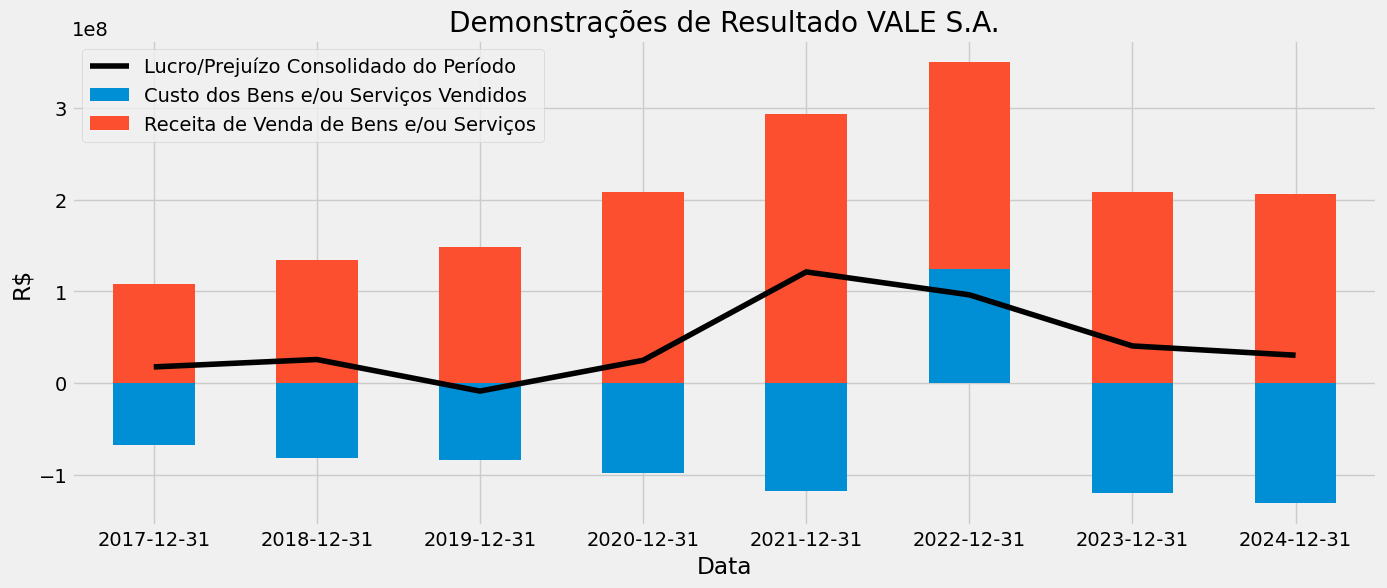

In [80]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Cria o gráfico da DRE
fig, ax = plt.subplots(figsize=(15, 6))

# Plotando as barras empilhadas
dre_pivot.drop(['Lucro/Prejuízo Consolidado do Período'], axis=1).plot(kind='bar', stacked=True, ax=ax)

# Plotando a linha preta para 'Lucro/Prejuízo Consolidado do Período'
dre_pivot[['Lucro/Prejuízo Consolidado do Período']].plot(ax=ax, color=['black'])

# Configurações do gráfico
ax.set_xlabel('Data')
ax.set_ylabel('R$')
ax.set_title(f'Demonstrações de Resultado {busca.upper()}')
ax.legend(loc='best')

plt.show()



## Lucro

In [81]:
lucro = tabela[tabela.CD_CONTA.isin(['3.11'])].pivot_table(index = 'ano',  values = 'VL_CONTA')
lucro.rename(columns={'VL_CONTA':'valor'},inplace=True)
lucro

,valor
ano,
2017,17669992.0
2018,25773768.0
2019,-8696040.0
2020,24902341.0
2021,121343000.0
2022,96337000.0
2023,40554000.0
2024,30431000.0


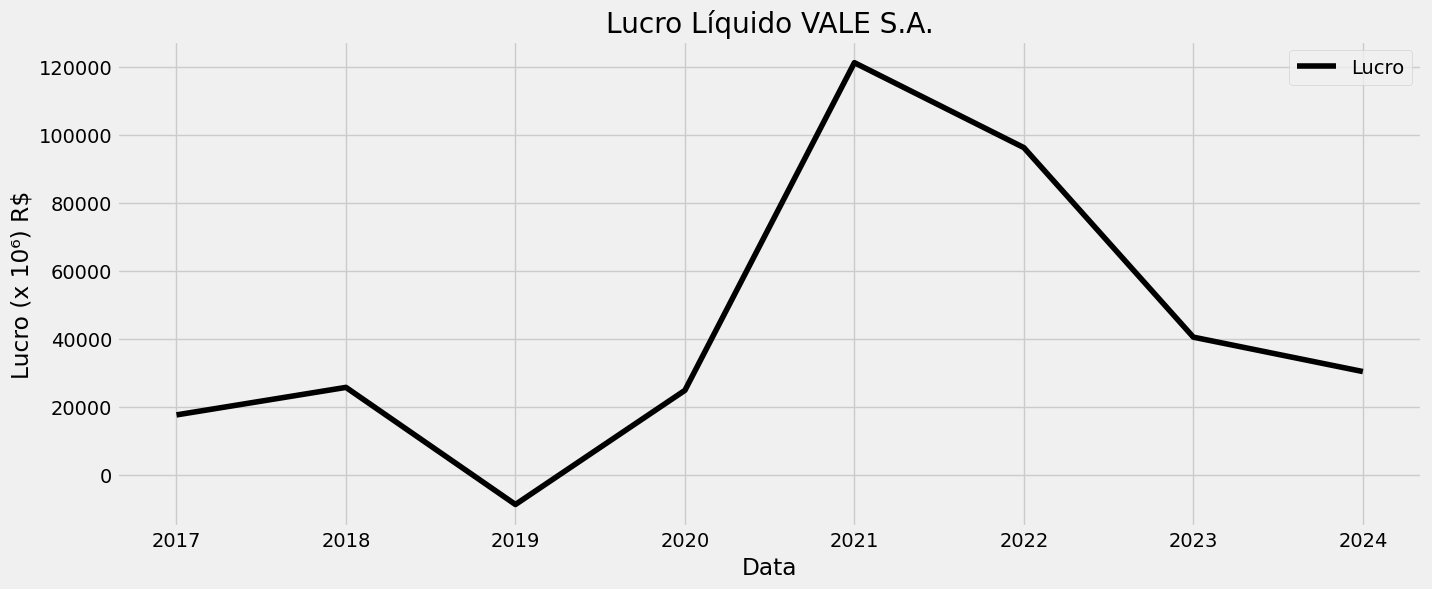

In [82]:
fig, ax = plt.subplots(figsize=(15, 6))

if tabela[tabela.CD_CONTA=='3.11']['ESCALA_MOEDA'].drop_duplicates().values[0] == 'MIL':
    div = 1000
else: div=1

ax.plot(lucro.index, lucro.valor/1000, color='black', label='Lucro')
ax.set_xlabel('Data')
ax.set_ylabel('Lucro (x 10⁶) R$')
ax.set_title(f'Lucro Líquido {busca.upper()}')
ax.legend(loc='best')

plt.show()

### Lucro por ação


In [83]:
tabela

,CNPJ_CIA,DT_REFER,VERSAO,DENOM_CIA,CD_CVM,GRUPO_DFP,MOEDA,ESCALA_MOEDA,ORDEM_EXERC,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA,ano
15383,33.592.510/0001-54,2017-12-31,1,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2017-01-01,2017-12-31,3.01,Receita de Venda de Bens e/ou Serviços,1.085320e+08,S,2017
15385,33.592.510/0001-54,2017-12-31,1,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2017-01-01,2017-12-31,3.02,Custo dos Bens e/ou Serviços Vendidos,-6.725731e+07,S,2017
15387,33.592.510/0001-54,2017-12-31,1,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2017-01-01,2017-12-31,3.03,Resultado Bruto,4.127471e+07,S,2017
15389,33.592.510/0001-54,2017-12-31,1,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2017-01-01,2017-12-31,3.04,Despesas/Receitas Operacionais,-6.741033e+06,S,2017
15391,33.592.510/0001-54,2017-12-31,1,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2017-01-01,2017-12-31,3.04.01,Despesas com Vendas,0.000000e+00,S,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228990,33.592.510/0001-54,2024-12-31,3,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,3.99.01.01,PNA,0.000000e+00,N,2024
228992,33.592.510/0001-54,2024-12-31,3,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,3.99.01.02,ON,7.390000e+00,N,2024
228994,33.592.510/0001-54,2024-12-31,3,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,3.99.02,Lucro Diluído por Ação,0.000000e+00,N,2024
228996,33.592.510/0001-54,2024-12-31,3,VALE S.A.,4170,DF Consolidado - Demonstração do Resultado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,3.99.02.01,PNA,0.000000e+00,N,2024


In [84]:
lpa = tabela[tabela.CD_CONTA.isin(['3.99.01.02'])].pivot_table(index = 'ano',  values = 'VL_CONTA')
lpa.rename(columns={'VL_CONTA':'valor'},inplace=True)
# lpa

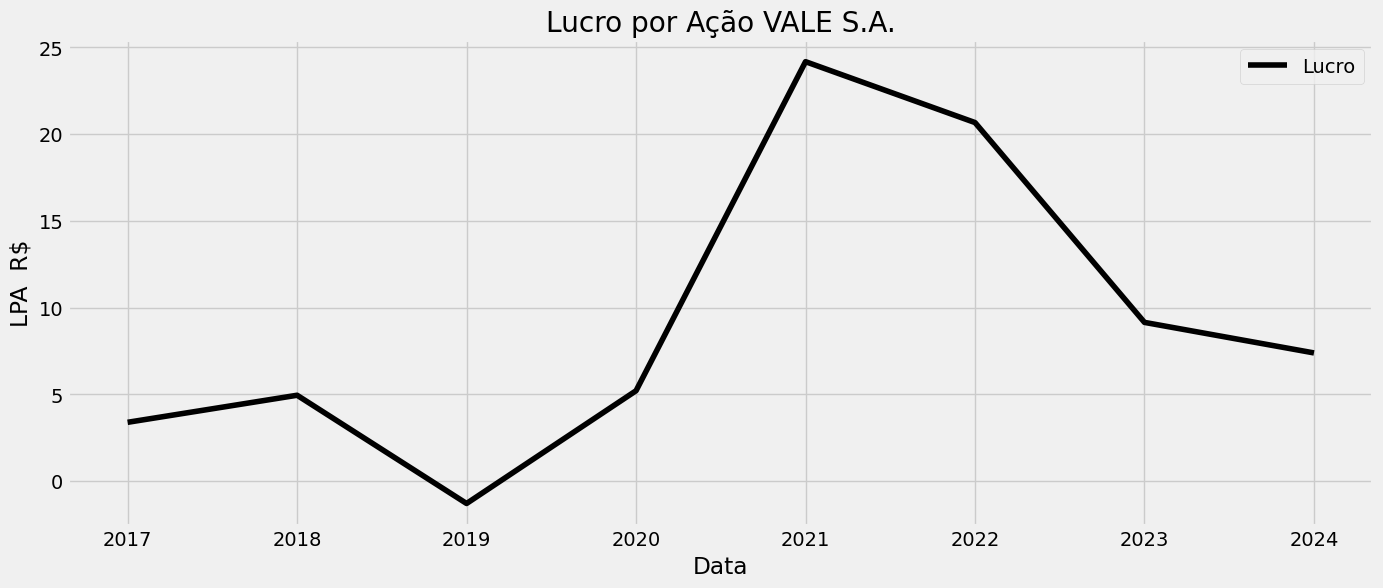

In [85]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(lpa.index, lpa.valor, color='black', label='Lucro')
ax.set_xlabel('Data')
ax.set_ylabel('LPA  R$')
ax.set_title(f'Lucro por Ação {busca.upper()}')
ax.legend(loc='best')
plt.show()

DRE

In [86]:
nova_tabela = show_table(tabela,filtro)
display(HTML(nova_tabela.reset_index().drop('CD_CONTA', axis = 1).to_html(index=False)))

DS_CONTA,2017,2017-2018 Δ%,2018,2018-2019 Δ%,2019,2019-2020 Δ%,2020,2020-2021 Δ%,2021,2021-2022 Δ%,2022,2022-2023 Δ%,2023,2023-2024 Δ%,2024
Receita de Venda de Bens e/ou Serviços,108532022.0,23.91,134483126.0,10.53,148639921.0,40.29,208528759.0,40.76,293524000.0,-22.83,226508000.0,-8.14,208066000.0,-0.99,206005000.0
Custo dos Bens e/ou Serviços Vendidos,-67257311.0,20.73,-81200904.0,3.24,-83835563.0,17.57,-98567494.0,18.97,-117267000.0,-205.91,124195000.0,-196.64,-120016000.0,9.42,-131318000.0
Resultado Bruto,41274711.0,29.09,53282222.0,21.62,64804358.0,69.68,109961265.0,60.29,176257000.0,-41.95,102313000.0,-13.94,88050000.0,-15.18,74687000.0
Despesas/Receitas Operacionais,-6741033.0,49.92,-10106478.0,519.05,-62564583.0,-7.47,-57893647.0,-39.68,-34922000.0,-65.67,-11987000.0,90.02,-22778000.0,-15.59,-19228000.0
Resultado Antes do Resultado Financeiro e dos Tributos,34533678.0,25.03,43175744.0,-94.81,2239775.0,2224.68,52067618.0,171.45,141335000.0,-36.09,90326000.0,-27.74,65272000.0,-15.03,55459000.0
Resultado Financeiro,-9649530.0,87.13,-18057519.0,-25.54,-13444786.0,79.55,-24140630.0,-173.78,17812000.0,-36.12,11378000.0,-185.41,-9718000.0,118.51,-21235000.0
Resultado Antes dos Tributos sobre o Lucro,24884148.0,0.94,25118225.0,-144.61,-11205011.0,-349.24,27926988.0,469.87,159147000.0,-36.09,101704000.0,-45.38,55554000.0,-38.40,34224000.0
Imposto de Renda e Contribuição Social sobre o Lucro,-4606567.0,-120.97,965980.0,159.73,2508971.0,-220.55,-3024647.0,737.12,-25320000.0,-40.03,-15185000.0,-1.22,-15000000.0,-74.71,-3793000.0
Resultado Líquido das Operações Continuadas,20277581.0,28.64,26084205.0,-133.34,-8696040.0,-386.36,24902341.0,437.41,133827000.0,-35.35,86519000.0,-53.13,40554000.0,-24.96,30431000.0
Lucro/Prejuízo Consolidado do Período,17669992.0,45.86,25773768.0,-133.74,-8696040.0,-386.36,24902341.0,387.28,121343000.0,-20.61,96337000.0,-57.90,40554000.0,-24.96,30431000.0


In [87]:
from great_tables import GT, md, html, style, loc

anos = [str(ano) for ano in range(ano_inicio, ano_fim + 1)]
outros = list(nova_tabela.columns.difference(anos))

gt = (
    GT(nova_tabela.reset_index().drop('CD_CONTA', axis = 1),
        rowname_col='DS_CONTA')
    .tab_header(title=md(f'**Demonstrações do Resultado de Exercício (DRE)** <br> **{empresa}**'))
    .tab_source_note(source_note=md("**Fonte: CVM**"))
    .fmt_currency(
        columns= anos,
        currency='BRL',
        locale='br'
    )
    .fmt_percent(
        columns= outros,
        scale_values=False,
        dec_mark=',',
        sep_mark='.'
    )
    .opt_all_caps(locations='column_labels')
    # .opt_align(align='center')  # Centralizar todas as colunas, se necessário
)

gt  # Apenas referenciando o objeto, caso ele seja automaticamente renderizável no ambiente


GT(_tbl_data=                                            DS_CONTA         2017  \
0             Receita de Venda de Bens e/ou Serviços  108532022.0   
1              Custo dos Bens e/ou Serviços Vendidos  -67257311.0   
2                                    Resultado Bruto   41274711.0   
3                     Despesas/Receitas Operacionais   -6741033.0   
4  Resultado Antes do Resultado Financeiro e dos ...   34533678.0   
5                               Resultado Financeiro   -9649530.0   
6         Resultado Antes dos Tributos sobre o Lucro   24884148.0   
7  Imposto de Renda e Contribuição Social sobre o...   -4606567.0   
8        Resultado Líquido das Operações Continuadas   20277581.0   
9              Lucro/Prejuízo Consolidado do Período   17669992.0   

   2017-2018 Δ%         2018  2018-2019 Δ%         2019  2019-2020 Δ%  \
0         23.91  134483126.0         10.53  148639921.0         40.29   
1         20.73  -81200904.0          3.24  -83835563.0         17.57   
2         29.09   53282222.0         21.62   64804358.0         69.68   
3         49.92  -10106478.0        519.05  -62564583.0         -7.47   
4         25.03   43175744.0        -94.81    2239775.0       2224.68   
5         87.13  -18057519.0        -25.54  -13444786.0         79.55   
6          0.94   25118225.0       -144.61  -11205011.0       -349.24   
7       -120.97     965980.0        159.73    2508971.0       -220.55   
8         28.64   26084205.0       -133.34   -8696040.0       -386.36   
9         45.86   25773768.0       -133.74   -8696040.0       -386.36   

          2020  2020-2021 Δ%         2021  2021-2022 Δ%         2022  \
0  208528759.0         40.76  293524000.0        -22.83  226508000.0   
1  -98567494.0         18.97 -117267000.0       -205.91  124195000.0   
2  109961265.0         60.29  176257000.0        -41.95  102313000.0   
3  -57893647.0        -39.68  -34922000.0        -65.67  -11987000.0   
4   52067618.0        171.45  141335000.0        -36.09   90326000.0   
5  -24140630.0       -173.78   17812000.0        -36.12   11378000.0   
6   27926988.0        469.87  159147000.0        -36.09  101704000.0   
7   -3024647.0        737.12  -25320000.0        -40.03  -15185000.0   
8   24902341.0        437.41  133827000.0        -35.35   86519000.0   
9   24902341.0        387.28  121343000.0        -20.61   96337000.0   

   2022-2023 Δ%         2023  2023-2024 Δ%         2024  
0         -8.14  208066000.0         -0.99  206005000.0  
1       -196.64 -120016000.0          9.42 -131318000.0  
2        -13.94   88050000.0        -15.18   74687000.0  
3         90.02  -22778000.0        -15.59  -19228000.0  
4        -27.74   65272000.0        -15.03   55459000.0  
5       -185.41   -9718000.0        118.51  -21235000.0  
6        -45.38   55554000.0        -38.40   34224000.0  
7         -1.22  -15000000.0        -74.71   -3793000.0  
8        -53.13   40554000.0        -24.96   30431000.0  
9        -57.90   40554000.0        -24.96   30431000.0  , _body=<great_tables._gt_data.Body object at 0x7f556a6e6790>, _boxhead=Boxhead([ColInfo(var='DS_CONTA', type=<ColInfoTypeEnum.stub: 2>, column_label='DS_CONTA', column_align='left', column_width=None), ColInfo(var='2017', type=<ColInfoTypeEnum.default: 1>, column_label='2017', column_align='right', column_width=None), ColInfo(var='2017-2018 Δ%', type=<ColInfoTypeEnum.default: 1>, column_label='2017-2018 Δ%', column_align='right', column_width=None), ColInfo(var='2018', type=<ColInfoTypeEnum.default: 1>, column_label='2018', column_align='right', column_width=None), ColInfo(var='2018-2019 Δ%', type=<ColInfoTypeEnum.default: 1>, column_label='2018-2019 Δ%', column_align='right', column_width=None), ColInfo(var='2019', type=<ColInfoTypeEnum.default: 1>, column_label='2019', column_align='right', column_width=None), ColInfo(var='2019-2020 Δ%', type=<ColInfoTypeEnum.default: 1>, column_label='2019-2020 Δ%', column_align='right', column_width=None), ColInfo(var='2020', type=<ColInfoT